In [1]:
# Prepare Mini-MNIST Dataset(Data Preprocessing)
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

digits = load_digits()

# digits.data from sklearn contains 1797 images of 8x8 pixels
# Each image has a hand-written digit
digits_df = digits.images.reshape((len(digits.target), -1))
digits_tf = digits.target

# Splitting dataframe into train & test
X_train_org, X_test_org, y_train_num, y_test = train_test_split(digits_df, digits_tf, test_size= 0.20, random_state= 101)

# Digits data has range of [0,16], which often lead too big exponential values
# so make them normal distribution of [0,1] with the sklearn package, or you can just divide them by 16
sc = StandardScaler()
X_train = sc.fit_transform(X_train_org)
X_test = sc.transform(X_test_org)

n_classes = 10

# Transform Nx1 Y vector into Nx10 answer vector, so that we can perform one-to-all classification
y_train = np.zeros((y_train_num.shape[0],10))
for i in range(n_classes):
    y_train[:,i] = (y_train_num == i)

In [2]:
# Activation function for forward path
def sigmoid(x): #sigmoid function
    # Numerically stable with large exponentials
    x = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return x

def softmax(x): #softmax function
    # Numerically stable with large exponentials
    x = x - np.max(x, axis=-1, keepdims=True)
    x = np.exp(x)
    xs = np.sum(x, axis=-1, keepdims=True)
    return x / xs

(1797, 64)
(1437, 64)
(1437, 10)
[ 0.  0.  0.  9. 16.  6.  0.  0.  0.  0.  4. 15.  6. 15.  0.  0.  0.  0.
  8. 11.  9. 11.  0.  0.  0.  0.  8. 16. 14.  2.  0.  0.  0.  0. 11. 16.
 13.  0.  0.  0.  0.  6. 14.  2. 12.  9.  0.  0.  0.  5. 16. 11.  5. 13.
  4.  0.  0.  0.  3.  8. 13. 16.  9.  0.]


<Figure size 640x480 with 0 Axes>

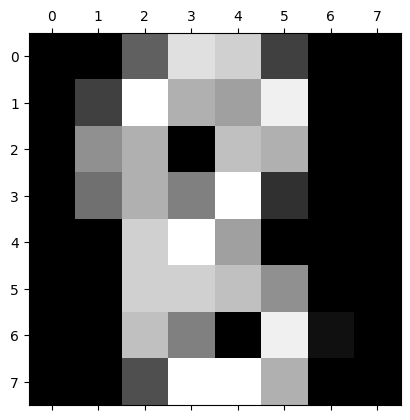

The number is 8


In [3]:
# check the data in the preprocessed data set
print(digits_df.shape)
print(X_train.shape)
print(y_train.shape)
print(X_train_org[0])

idx = np.random.randint(X_train.shape[0])
dimage = X_train_org[idx].reshape((8,8))
# plt.figure(figsize=(4.32, 2.88))  # Adjust the width and height as needed
plt.gray()
plt.matshow(dimage)
plt.show()
print('The number is', y_train_num[idx])  # the number that is predicted


In [4]:
# Define Model class (Linear prediction for each function (forward,backward))
class myDenseLayer:
    def __init__(self, n_out, n_in):
        self.wegt = np.zeros((n_out, n_in))
        self.bias = np.zeros((n_out))

    def forward(self, x):       # (b, i)
        ### START CODE HERE ###

        x_lin = (self.wegt @x.T).T + self.bias  # Linear Prediction

        ### END CODE HERE ###
        return x_lin

    def backward(self, x, x_in):  # x = dJ/dz (b, c)
        ### START CODE HERE ###
        m = x.shape[1]  # the total number
        dw = (x.T @ x_in)/m  # Gradients for weights
        db = (np.sum(x, axis=0))/m  # Gradients for biases
        wdJdz =  x @ self.wegt # Propagation for lower layer

        ### END CODE HERE ###
        return dw, db, wdJdz


In [5]:
# Code for checking backward path process
np.random.seed(0)

tmp2 = myDenseLayer(2,5)
tmp2.wegt = np.random.randn(2,5)
tmp2.bias = np.random.randn(2)

x_in_t = np.random.randn(2,5)
x_t = np.random.randn(2,2)

dw2, db2, wdJdz2 = tmp2.backward(x_t,x_in_t)

print(f"x_t = \n{x_t}")
print(f"dw2 = \n{dw2}")
print(f"db2 = \n{db2}")
print(f"wdJdz2 = \n{wdJdz2}")

x_t = 
[[ 0.8644362  -0.74216502]
 [ 2.26975462 -1.45436567]]
dw2 = 
[[ 0.09610482  0.40788358 -0.77744815 -2.75311014  1.38754493]
 [-0.13322022 -0.27280893  0.45637388  1.73266967 -1.02972684]]
db2 = 
[ 1.56709541 -1.09826535]
wdJdz2 = 
[[ 2.25021216 -0.35921201  0.95838857  2.01371462  1.30965288]
 [ 5.42528537 -0.47351731  2.44162379  5.23639566  3.64173802]]


In [6]:
# activation functions for the backpropagation.
def dJdz_sigmoid(wdJdz_upper, az):   # sigmoid function for backward
    dJdz = wdJdz_upper * az * (1 - az)
    return dJdz

def dJdz_softmax(y_hat, y):
    dJdz = y_hat - y   # softmax function for backward
    return dJdz

In [7]:
# Define Training Functions
def my_forward(layers, X_in):
    l1, l2, l3 = layers
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))                   # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                    # third stage forward

    ### END CODE HERE ###
    return a_1, a_2, a_3

def my_backward(layers, a_1, a_2, a_3, X_in, y_true):
    l1, l2, l3 = layers
    ### START CODE HERE ###

    dw_3, db_3, wdJdz_3 = l3.backward(dJdz_softmax(a_3, y_true), a_2)  # go through 3rd stage backward
    dw_2, db_2, wdJdz_2 = l2.backward(dJdz_sigmoid(wdJdz_3, a_2), a_1)  # go through 2nd stage backward
    dw_1, db_1, _ = l1.backward(dJdz_sigmoid(wdJdz_2, a_1), X_in)     # go through 1st stage backward

    ### END CODE HERE ###
    d_1 = [dw_1, db_1]
    d_2 = [dw_2, db_2]
    d_3 = [dw_3, db_3]
    return d_1, d_2, d_3

def my_loss(layers, X_in, y_true):
    l1, l2, l3 = layers
    ### START CODE HERE ###

    a_1, a_2, a_3 = my_forward(layers, X_in)
    loss = -np.mean(np.sum(y_true * np.log(a_3), axis=1))  # calculate loss

    ### END CODE HERE ###
    return loss

def my_predict(layers, X_in):
    l1, l2, l3 = layers
    ### START CODE HERE ###

    a_1, a_2, a_3 = my_forward(layers, X_in)
    pred = np.argmax(a_3, axis=1)  # make prediction

    ### END CODE HERE ###
    return pred


In [8]:
# set the parameters of each layer.
n_inputs  = 64
n_hidden1 = 80
n_hidden2 = 70
n_classes = 10

l1 = myDenseLayer(n_hidden1, n_inputs)
l2 = myDenseLayer(n_hidden2, n_hidden1)
l3 = myDenseLayer(n_classes, n_hidden2)

layers = [l1, l2, l3]
print(X_train.shape, y_train.shape)
print(l1.wegt.shape, l1.bias.shape)
print(l2.wegt.shape, l2.bias.shape)
print(l3.wegt.shape, l3.bias.shape)

(1437, 64) (1437, 10)
(80, 64) (80,)
(70, 80) (70,)
(10, 70) (10,)


In [9]:
# Initialize the weights
l1.wegt = np.random.randn(n_hidden1, n_inputs)
l2.wegt = np.random.randn(n_hidden2, n_hidden1)
l3.wegt = np.random.randn(n_classes, n_hidden2)

In [10]:
# Define a function for Splitting Dataset into mini-Batches (create_mini_batch)
def create_mini_batches(X, y, batch_size=64):
    mini_batches = []
    n_minibatches = X.shape[0] // batch_size  # the number of minibatches
    n_variables = X.shape[1]  # the number of variables

    data = np.hstack((X, y))
    np.random.shuffle(data)
    # uee the loop for trainig the entire dataset (the whole batch is epoch)
    for i in range(n_minibatches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        mini_batch = data[start_idx:end_idx]

        X_mini = mini_batch[:, :n_variables]  # split the datset
        y_mini = mini_batch[:, n_variables:]
        mini_batches.append((X_mini, y_mini)) # append by the end of the dataset

    if data.shape[0] % batch_size != 0:
        remaining_data = data[n_minibatches * batch_size:]
        X_mini = remaining_data[:, :n_variables]  # split the datset
        y_mini = remaining_data[:, n_variables:]
        mini_batches.append((X_mini, y_mini)) # append by the end of the dataset

    return mini_batches


In [11]:
# check the result of the 'create_mini_batches' function
np.random.seed(1)

a = np.arange(20).reshape(10,2)
b = -np.arange(10,20).reshape(10,1)
# check the function(create_mini_batches)
c = create_mini_batches(a, b, 4)
for mini_X, mini_y in c:
    print(mini_X)
    print(mini_y, '\n')


[[ 4  5]
 [18 19]
 [12 13]
 [ 8  9]]
[[-12]
 [-19]
 [-16]
 [-14]] 

[[ 0  1]
 [ 6  7]
 [ 2  3]
 [14 15]]
[[-10]
 [-13]
 [-11]
 [-17]] 

[[16 17]
 [10 11]]
[[-18]
 [-15]] 



In [12]:
# Define Various Optimizers
class myOptParam:
    def __init__(self, n_out, n_in):
        # Previoud delta values for momentum optimizer
        self.W_dt = np.zeros((n_out, n_in))
        self.B_dt = np.zeros(n_out)
        # Variables for other optimizers
        self.W_mt = np.zeros((n_out, n_in))
        self.B_mt = np.zeros(n_out)
        self.W_vt = np.zeros((n_out, n_in))
        self.B_vt = np.zeros(n_out)
# optimizer functions (sgd, momentum, adagrad, rmsprop, adam)
def my_optimizer(lyr, opt, W_grad, B_grad, solver='sgd', learning_rate=0.01, iter=1):
    epsilon = 1e-8  # arbitrary small number
    alpha = eta = learning_rate
    if iter==0:
        print('iteration should start from 1.')

    # optimizer routines
    if  solver=='sgd':  # Stochastic Gradient
        W_dlt = alpha * W_grad
        B_dlt = alpha * B_grad
    elif solver=='momentum':   # SGD with momentum
        gamma = 0.9               # default setting
        ### START CODE HERE ###

        W_dlt = alpha * W_grad + gamma * opt.W_dt  # momentum for previous delta
        B_dlt = alpha * B_grad + gamma * opt.B_dt # same goes for bias
        opt.W_dt = W_dlt # keep data for later use
        opt.B_dt = B_dlt # for bias, too


        ### END CODE HERE ###
    elif solver=='adagrad':   # AdaGrad
        ### START CODE HERE ###
        opt.W_vt += W_grad ** 2 # accumulate delta square (2nd momentum
        opt.B_vt += B_grad ** 2 # accumulater for bias term
        W_dlt = (alpha / (np.sqrt(opt.W_vt) + epsilon)) * W_grad # calculate new delta for weight
        B_dlt = (alpha / (np.sqrt(opt.B_vt) + epsilon)) * B_grad # and for bias
    elif solver=='rmsprop':   # rmsprop
        beta2 = 0.9               # default setting
        ### START CODE HERE ###

        opt.W_vt = beta2 * opt.W_vt + (1 - beta2) * W_grad ** 2 # blending with second momentum
        opt.B_vt = beta2 * opt.B_vt + (1 - beta2) * B_grad ** 2 # also doging samething for bias
        W_dlt = (alpha / (np.sqrt(opt.W_vt) + epsilon)) * W_grad  # calculate new delta for weight
        B_dlt = (alpha / (np.sqrt(opt.B_vt) + epsilon)) * B_grad  # and for bias
        ### END CODE HERE ###
    elif solver=='adam':  # adam
        beta1, beta2 = 0.9, 0.99  # default setting
        ### START CODE HERE ###

        opt.W_mt = beta1 * opt.W_mt + (1 - beta1) * W_grad  # blending with first momentum
        opt.B_mt = beta1 * opt.B_mt + (1 - beta1) * B_grad  # first momentum for bias
        opt.W_vt = beta2 * opt.W_vt + (1 - beta2) * W_grad ** 2 # blending with second momentum
        opt.B_vt = beta2 * opt.B_vt + (1 - beta2) * B_grad ** 2 # second momentum for bias
        W_mc = opt.W_mt / (1 - beta1 ** iter) # bias correction of first momentum for weight
        B_mc = opt.B_mt / (1 - beta1 ** iter) # and for bias term
        W_vc = opt.W_vt / (1 - beta2 ** iter) # bias correction of second momentum for weight
        B_vc = opt.B_vt / (1 - beta2 ** iter) # and for bias term
        W_dlt = (alpha / (np.sqrt(W_vc) + epsilon)) * W_mc  # calculate new delat for weight
        B_dlt = (alpha / (np.sqrt(B_vc) + epsilon)) * B_mc   # and for bias

        ### END CODE HERE ###
    else:
        print('optimizer error')

    # Adjust weight
    lyr.wegt = lyr.wegt - W_dlt
    lyr.bias = lyr.bias - B_dlt

    return

In [21]:
# Optimizer Test
np.random.seed(1)

lyr = myDenseLayer(2,3)
opt = myOptParam(2,3)

lyr.wegt = np.random.randn(2,3)
lyr.bias = np.random.randn(2)
opt.W_dt = np.random.randn(2,3)
opt.B_dt = np.random.randn(2)
opt.W_mt = np.random.randn(2,3)
opt.B_mt = np.random.randn(2)
opt.W_vt = np.abs(np.random.randn(2,3))
opt.B_vt = np.abs(np.random.randn(2))

W_grad = np.random.randn(2,3)
B_grad = np.random.randn(2)

# optimizer settings are: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
#Check comment on/off as appropriate

my_optimizer(lyr, opt, W_grad, B_grad, 'sgd', 10, 3)
print("For SGD:")
print(lyr.wegt[0], lyr.bias[0])
# my_optimizer(lyr, opt, W_grad, B_grad, 'momentum', 10, 3)
# print("For Momentum:")
# print(lyr.wegt[0], lyr.bias[0])
# my_optimizer(lyr, opt, W_grad, B_grad, 'adagrad', 10, 3)
# print("For Adagrad:")
# print(lyr.wegt[0], lyr.bias[0])
# my_optimizer(lyr, opt, W_grad, B_grad, 'rmsprop', 10, 3)
# print("For RMSProp:")
# print(lyr.wegt[0], lyr.bias[0])
# my_optimizer(lyr, opt, W_grad, B_grad, 'adam', 10, 3)
# print("For adam:")
# print(lyr.wegt[0], lyr.bias[0])

For SGD:
[8.49607236 7.8403     6.18428956] -14.853210006882223


In [18]:
# Create Opimizer Parameters (apply function to each layer)
o1 = myOptParam(n_hidden1, n_inputs)
o2 = myOptParam(n_hidden2, n_hidden1)
o3 = myOptParam(n_classes, n_hidden2)

In [19]:
#Trainig Simple Neural Network Model(3 layer model)
# optimizer settings are: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
# alpha is learning rate
optimizer ='sgd'  # set the optimizer
alpha = 0.01  # set the value of alpha that is learning rate.
n_epochs = 1000 # set the number of epochs

for epoch in range(n_epochs):

    batches = create_mini_batches(X_train, y_train, batch_size=64)
    for one_batch in batches:
        X_mini, y_mini = one_batch
        batch_len = X_mini.shape[0]  # last batch might have different length

        # Forward Path
        a_1, a_2, a_3 = my_forward(layers, X_mini)

        # Backward Path
        d_1, d_2, d_3 = my_backward(layers, a_1, a_2, a_3, X_mini, y_mini)

        dw_1, db_1 = d_1
        dw_2, db_2 = d_2
        dw_3, db_3 = d_3

        # Update weights and biases
        my_optimizer(l1, o1, dw_1, db_1, solver=optimizer, learning_rate=alpha, iter=epoch+1)
        my_optimizer(l2, o2, dw_2, db_2, solver=optimizer, learning_rate=alpha, iter=epoch+1)
        my_optimizer(l3, o3, dw_3, db_3, solver=optimizer, learning_rate=alpha, iter=epoch+1)

    if ((epoch+1)%100==0):
        loss_J = my_loss(layers, X_train, y_train)
        print('Epoch: %4d,  loss: %10.8f' % (epoch+1, loss_J))

Epoch:  100,  loss: 0.34530735
Epoch:  200,  loss: 0.19123897
Epoch:  300,  loss: 0.12508008
Epoch:  400,  loss: 0.08817055
Epoch:  500,  loss: 0.06534233
Epoch:  600,  loss: 0.05036992
Epoch:  700,  loss: 0.04011914
Epoch:  800,  loss: 0.03284979
Epoch:  900,  loss: 0.02752606
Epoch: 1000,  loss: 0.02351377


In [20]:
# Evaluate Model Performance
from sklearn.metrics import accuracy_score

y_pred = my_predict(layers, X_test)
# calculate the accuracy
accuracy_score(y_pred, y_test)

0.9388888888888889

In [129]:
# Neural Network from scikit-learn
from sklearn.neural_network import MLPClassifier
# set the parameters of MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(80, 70, ), activation='logistic', solver='sgd', \
                    alpha=0.01, learning_rate_init=0.01, max_iter=1000)

# Training/Fitting the Model
mlp.fit(X_train, y_train_num)

# Making Predictions
s_pred = mlp.predict(X_test)
accuracy_score(s_pred, y_test)  # calculate the accuray

0.9694444444444444

<Figure size 640x480 with 0 Axes>

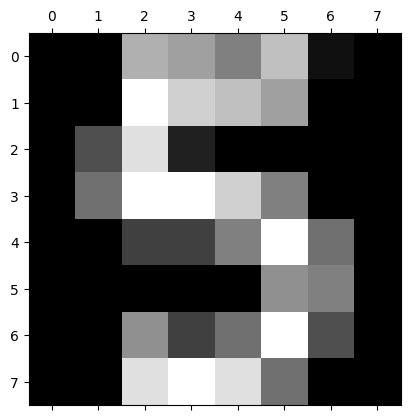

My prediction is 5
sk prediction is 5
Actual number is 5


In [130]:
#Test Model with a random sample
idx = np.random.randint(X_test.shape[0])
dimage = X_test_org[idx].reshape((8,8))
plt.gray()
plt.matshow(dimage)
plt.show()

X_input = np.expand_dims(X_test[idx], 0)

y_pred = my_predict(layers, X_input)

s_pred = mlp.predict(X_input)
# print out the predicted number.
print('My prediction is ' + str(y_pred[0]))
print('sk prediction is ' + str(s_pred[0]))
print('Actual number is ' + str(y_test[idx]))
